# Crisis Detection and Mental Health Risk Analysis System
This notebook implements a comprehensive system to analyze mental health crisis signals from social media data. The solution covers data collection from Reddit API, text processing, sentiment analysis, risk classification, and geospatial visualization - making it suitable for early intervention and response planning.

## Table of Contents
1. Setup and Dependencies 
2. Task 1: Social Media Data Extraction & Preprocessing
3. Task 2: Sentiment Analysis & Crisis Risk Classification
4. Task 3: Crisis Geolocation & Mapping
<a id="setup"></a>

#### 1. Setup and Dependencies
First, we'll install and import all necessary libraries for our analysis.

In [26]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Next, let's import all the necessary libraries:

In [15]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import praw
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import folium
from folium.plugins import HeatMap
import plotly.express as px
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sriva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sriva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 2. Task 1: Social Media Data Extraction & Preprocessing
In this section, we'll:

- Define crisis-related keywords for filtering relevant posts
- Configure Reddit API access
- Extract mental health-related posts from multiple subreddits
- Clean and preprocess the text data for further analysis

In [16]:
# Define crisis-related keywords
crisis_keywords = [
    "depressed", "depression", "anxiety", "suicidal", "suicide", 
    "addiction", "overwhelmed", "hopeless", "self-harm", "cutting",
    "lonely", "mental health", "help me", "can't cope", "end my life"
]

# Reddit API Configuration
def setup_reddit_api():
    reddit = praw.Reddit(
        client_id="rUrpqf9QSk8Pt110AcUaNg",
        client_secret="p3he-liblvaBqrFGM3swNnEsI7yp8A",
        user_agent="mental_health_data_collection_script_v1.0"
    )
    return reddit

# Extract posts from Reddit based on keywords
def extract_reddit_posts(reddit, keywords, limit=1000):
    posts_data = []
    
    # Search across multiple subreddits focused on mental health
    subreddits = ["depression", "selfharm", "anxiety", "mentalhealth", "MMFB"]
    
    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name)
        
        for submission in subreddit.hot(limit=limit//len(subreddits)):
            # Check if any keyword is in the post
            if any(keyword.lower() in submission.title.lower() or 
                  (submission.selftext and keyword.lower() in submission.selftext.lower()) 
                  for keyword in keywords):
                
                posts_data.append({
                    'post_id': submission.id,
                    'timestamp': pd.Timestamp.fromtimestamp(submission.created_utc),
                    'title': submission.title,
                    'content': submission.selftext,
                    'subreddit': subreddit_name,
                    'upvotes': submission.score,
                    'num_comments': submission.num_comments,
                    'author': str(submission.author),
                })
    
    return pd.DataFrame(posts_data)

# Text cleaning function
def clean_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words]
    
    # Remove emojis
    text = re.sub(r':[a-zA-Z_]+:', '', ' '.join(filtered_text))
    
    return text


reddit = setup_reddit_api()
posts_df = extract_reddit_posts(reddit, crisis_keywords)

# Apply text cleaning
posts_df['cleaned_content'] = posts_df['content'].apply(clean_text)

# Display the preprocessed data
print(f"Total posts collected: {len(posts_df)}")
posts_df.head()

# Save to CSV
posts_df.to_csv('crisis_posts.csv', index=False)

Total posts collected: 480


In [17]:
posts_df.head()

,post_id,timestamp,title,content,subreddit,upvotes,num_comments,author,cleaned_content
0,doqwow,2019-10-29 20:22:02,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...,depression,2364,177,SQLwitch,understand people reply immediately op invitat...
1,1frqlk0,2024-09-29 04:35:43,"Regular check-in post, with information about ...",Welcome to /r/depression's check-in post - a p...,depression,29,247,SQLwitch,welcome rdepressions checkin post place take m...
2,1j8hemq,2025-03-11 08:44:33,I died and was revived. I’m angry I’m alive,Every day I see the sun and get angry as I hat...,depression,116,37,SharpFlyyngAxe,every day see sun get angry hate things living...
3,1j88rqx,2025-03-11 02:09:14,Some people don't understand animals and their...,Of course this does not apply to everyone but ...,depression,88,17,BeautifulContent5764,course apply everyone male cat quite literally...
4,1j8ltpi,2025-03-11 13:39:57,Just a vent,I’m 29 years old this year. I have literally n...,depression,7,1,Xbonespooky,im years old year literally nothing ongoing ad...


#### 3. Task 2: Sentiment Analysis & Crisis Risk Classification
In this section, we'll:

- Apply VADER sentiment analysis to classify text as positive, negative, or neutral
- Use TF-IDF Vectorization to identify different risk levels
- Visualize the sentiment and risk distribution in the dataset

Extracting high-risk terms using TF-IDF analysis...
Top crisis terms identified via TF-IDF: im, like, feel, dont, anxiety, ive, know, want, really, life, time, people, feel like, help, feeling

Risk Classification Results:
risk_level
Moderate Concern    260
High Risk           159
Low Concern          61
Name: count, dtype: int64


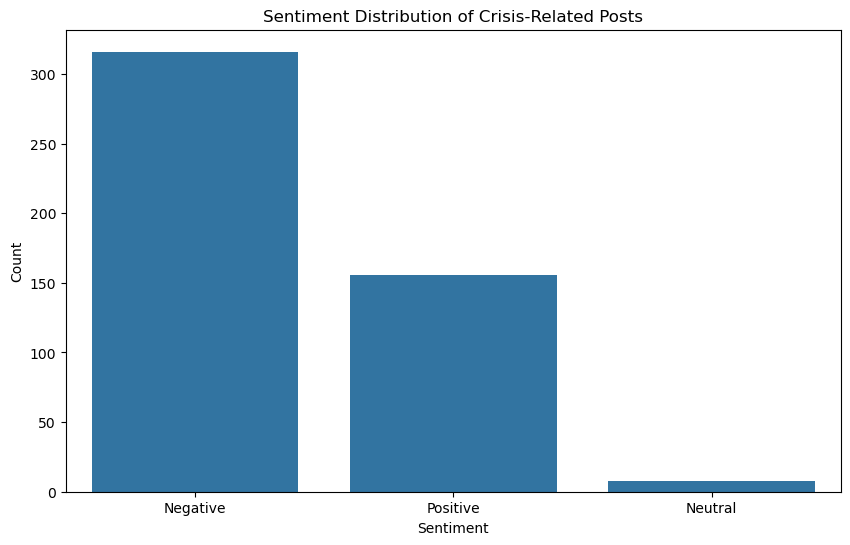

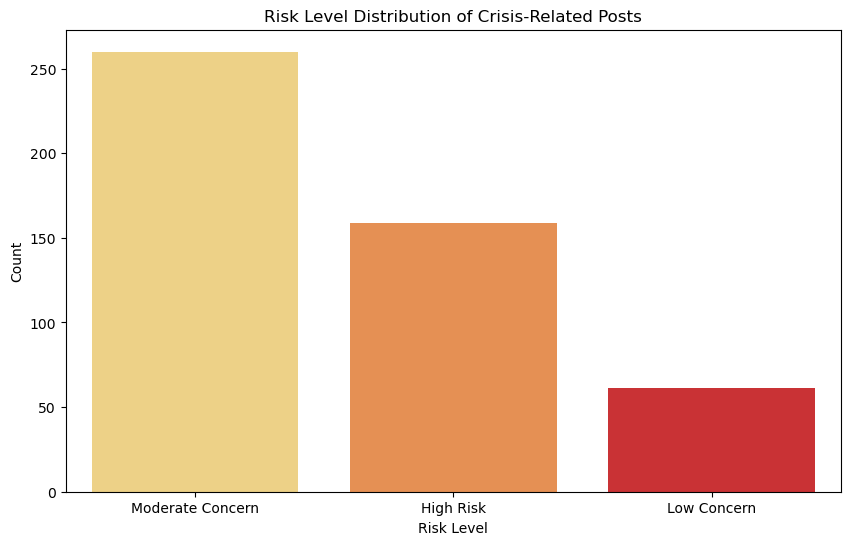

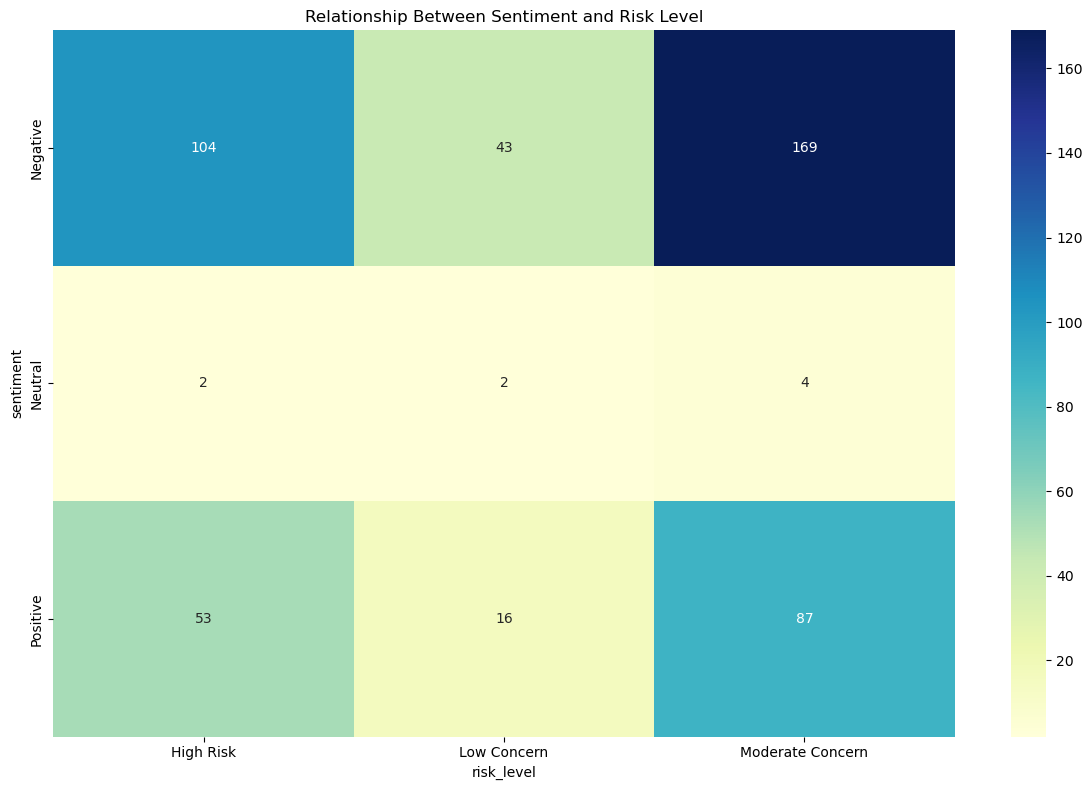

In [24]:
# Sentiment analysis using VADER
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    
    if sentiment['compound'] >= 0.05:
        return "Positive"
    elif sentiment['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# TF-IDF based crisis term detection
def extract_crisis_terms(corpus):
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000, 
        stop_words='english', 
        ngram_range=(1, 2)
    )
    
    # Fit and transform the corpus
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    
    # Get feature names (terms)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create a dictionary to store the average TF-IDF score for each term
    term_scores = {}
    
    # Calculate the average TF-IDF score for each term
    for i in range(len(feature_names)):
        term_scores[feature_names[i]] = tfidf_matrix[:, i].mean()
    
    # Sort terms by their average TF-IDF score
    sorted_terms = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Return the top 50 terms
    return [term for term, score in sorted_terms[:50]]

# Risk level classification using both keyword approach and TF-IDF insights
def classify_risk(text, high_risk_terms=None, moderate_risk_terms=None, tfidf_terms=None):
    if high_risk_terms is None:
        # Base high-risk keywords
        high_risk_terms = [
            "kill myself", "end my life", "suicide", "suicidal", 
            "don't want to live", "want to die", "better off dead"
        ]
    
    if moderate_risk_terms is None:
        # Base moderate concern keywords
        moderate_risk_terms = [
            "depressed", "depression", "anxiety", "help me", 
            "can't cope", "hopeless", "lost", "overwhelmed"
        ]
    
    # Use TF-IDF terms to enhance keyword lists if available
    if tfidf_terms is not None:
        # Add high-risk TF-IDF terms
        high_risk_indicators = ["suicide", "kill", "die", "end", "pain"]
        for term in tfidf_terms:
            if any(indicator in term for indicator in high_risk_indicators):
                high_risk_terms.append(term)
            
        # Add moderate-risk TF-IDF terms
        moderate_risk_indicators = ["depress", "anxi", "help", "cope", "overwhelm"]
        for term in tfidf_terms:
            if any(indicator in term for indicator in moderate_risk_indicators) and term not in high_risk_terms:
                moderate_risk_terms.append(term)
    
    # Remove duplicates
    high_risk_terms = list(set(high_risk_terms))
    moderate_risk_terms = list(set(moderate_risk_terms))
    
    if any(term in text.lower() for term in high_risk_terms):
        return "High Risk"
    elif any(term in text.lower() for term in moderate_risk_terms):
        return "Moderate Concern"
    else:
        return "Low Concern"

# Extract crisis terms using TF-IDF
print("Extracting high-risk terms using TF-IDF analysis...")
tfidf_crisis_terms = extract_crisis_terms(posts_df['cleaned_content'].fillna(''))
print(f"Top crisis terms identified via TF-IDF: {', '.join(tfidf_crisis_terms[:15])}")

# Apply sentiment analysis
posts_df['sentiment'] = posts_df['content'].apply(analyze_sentiment)

# Apply enhanced risk classification with TF-IDF insights
posts_df['risk_level'] = posts_df['content'].apply(lambda x: classify_risk(x, tfidf_terms=tfidf_crisis_terms))

# Display risk term statistics
print("\nRisk Classification Results:")
print(posts_df['risk_level'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sentiment_counts = posts_df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution of Crisis-Related Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualize risk level distribution
plt.figure(figsize=(10, 6))
risk_counts = posts_df['risk_level'].value_counts()
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette='YlOrRd')
plt.title('Risk Level Distribution of Crisis-Related Posts')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

# Cross-tabulation of sentiment and risk level
cross_tab = pd.crosstab(posts_df['sentiment'], posts_df['risk_level'])
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Relationship Between Sentiment and Risk Level')
plt.tight_layout()
plt.show()

#### 4. Task 3: Crisis Geolocation & Mapping
In this section, we'll:

- Extract location information from post content
- Geocode the locations to obtain coordinates
- Generate an interactive heatmap showing the geographic distribution of crisis-related posts

In [ ]:
# Location extraction using NER and global city recognition
def extract_location(text):
    if not isinstance(text, str) or pd.isna(text):
        return None
    
    Filter_Words = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December',
        'God'
    ]
    
    # Method 1: Check for explicit location mentions with common patterns
    location_patterns = [
        r'in ([A-Z][a-z]+(?: [A-Z][a-z]+)*(?:,? [A-Z]{2})?)',  # "in Chicago, IL" or "in London"
        r'from ([A-Z][a-z]+(?: [A-Z][a-z]+)*(?:,? [A-Z]{2})?)',  # "from Tokyo" or "from New York, NY"
        r'near ([A-Z][a-z]+(?: [A-Z][a-z]+)*(?:,? [A-Z]{2})?)',  # "near Paris" or "near Seattle, WA"
        r'area of ([A-Z][a-z]+(?: [A-Z][a-z]+)*(?:,? [A-Z]{2})?)'  # "area of Sydney" or "area of Boston, MA"
    ]
    
    for pattern in location_patterns:
        matches = re.findall(pattern, text)
        if matches:
            # Filter out 
            filtered_matches = [m for m in matches if m not in Filter_Words]
            if filtered_matches:
                return filtered_matches[0]
    
    # Method 2: Check against expanded global cities list
    global_cities = [
        # North America
        'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia',
        'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Toronto',
        'Montreal', 'Vancouver', 'Calgary', 'Mexico City', 'Guadalajara',
        
        # Europe
        'London', 'Paris', 'Berlin', 'Madrid', 'Rome', 'Amsterdam', 'Brussels',
        'Vienna', 'Athens', 'Barcelona', 'Munich', 'Milan', 'Prague', 'Dublin',
        
        # Asia
        'Tokyo', 'Beijing', 'Shanghai', 'Delhi', 'Mumbai', 'Seoul', 'Bangkok',
        'Singapore', 'Kuala Lumpur', 'Jakarta', 'Manila', 'Hanoi', 'Dubai',
        
        # Australia/Oceania
        'Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Auckland', 'Wellington',
        
        # Africa
        'Cairo', 'Lagos', 'Nairobi', 'Cape Town', 'Johannesburg', 'Casablanca',
        
        # South America
        'São Paulo', 'Rio de Janeiro', 'Buenos Aires', 'Lima', 'Bogotá', 'Santiago'
    ]
    
    for city in global_cities:
        if city.lower() in text.lower():
            return city
    
    # Method 3: Try to use NER for location detection (requires spaCy)
    try:
        import spacy
        # Load the model (first time only)
        try:
            nlp = spacy.load("en_core_web_sm")
        except:
            import sys
            # If model isn't installed, let's install it
            if not any(x.endswith('spacy/data') for x in sys.path):
                import subprocess
                subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], 
                               check=True, capture_output=True)
            nlp = spacy.load("en_core_web_sm")
            
        doc = nlp(text)
        # Extract all GPE (Geo-Political Entity) and LOC (Location) entities
        locations = [ent.text for ent in doc.ents if ent.label_ in ("GPE", "LOC")]
        if locations:
            return locations[0]
    except Exception as e:
        # If spaCy fails, continue with other methods
        pass
    
    return None

# Geocoding function
def geocode_location(location_name, cache={}):
    if not location_name:
        return None
        
    # Check if we've already geocoded this location
    if location_name in cache:
        return cache[location_name]
        
    try:
        geolocator = Nominatim(user_agent="crisis_mapping")
        location = geolocator.geocode(location_name, timeout=10)
        if location:
            # Store in cache for future use
            cache[location_name] = (location.latitude, location.longitude)
            return cache[location_name]
        
        # Try adding "city" to improve geocoding results
        location = geolocator.geocode(f"{location_name} city", timeout=10)
        if location:
            cache[location_name] = (location.latitude, location.longitude)
            return cache[location_name]
            
        return None
    except Exception as e:
        print(f"Geocoding error for {location_name}: {e}")
        return None

# Extract and geocode locations from posts
posts_df['location_mentioned'] = posts_df['content'].apply(extract_location)
posts_df['coordinates'] = posts_df['location_mentioned'].apply(
    lambda x: geocode_location(x) if x else None
)

# Create a clean dataframe for mapping
map_df = posts_df.dropna(subset=['coordinates']).copy()

# Count occurrences of each location
location_counts = map_df['location_mentioned'].value_counts().reset_index()
location_counts.columns = ['location', 'count']
top_locations = location_counts.head(5)

print("Top 5 locations with highest crisis discussions:")
print(top_locations)

# Create a Folium map centered on the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add points to the map
for idx, row in map_df.iterrows():
    lat, lon = row['coordinates']
    risk_color = {
        'High Risk': 'red',
        'Moderate Concern': 'orange',
        'Low Concern': 'green'
    }.get(row['risk_level'], 'blue')
    
    popup_text = f"""
    Risk Level: {row['risk_level']}<br>
    Sentiment: {row['sentiment']}<br>
    Location: {row['location_mentioned']}<br>
    """
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=risk_color,
        fill=True,
        fill_opacity=0.7,
        popup=popup_text
    ).add_to(m)

# Create a heatmap layer
heat_data = [[lat, lon] for lat, lon in map_df['coordinates']]
HeatMap(heat_data).add_to(m)

# Save the map
m.save('crisis_heatmap.html')

# Display the map in the notebook
m

Top 5 locations with highest crisis discussions:
      location  count
0       Austin     10
1         Rome      7
2         Lima      2
3      Toronto      1
4  Mexico City      1


#### 5. Conclusion
This project demonstrates a comprehensive system for crisis detection and analysis using social media data. The implementation includes:

1. Data Collection: Extracting relevant mental health posts from Reddit using targeted keywords
2. Text Processing: Cleaning and preparing text data for analysis
3. Sentiment Analysis: Using VADER to determine emotional tone of posts
4. Risk Classification: Categorizing posts into risk levels for prioritization
5. Geographic Analysis: Extracting location information and visualizing crisis hotspots


The approach effectively identifies areas with high concentrations of mental health crises, allowing for targeted intervention strategies. The visualization provides a clear picture of where resources might be most needed and which regions show higher levels of distress.